# Importing libraries

In [98]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
from Binance_API import BinanceAPI
from RiskMetrics import RiskAnalysis
import yfinance as yf
from Stock_Data import get_close
from Rebalancing import *

from Git import *

In [100]:
Binance=BinanceAPI(binance_api_key,binance_api_secret)
git=GitHub(token,repo_owner,repo_name,branch)

# Importing Data

In [103]:
start_date=datetime.datetime(2020,1,1)
today=datetime.datetime.today()

In [105]:
days=(today-start_date).days
days

2036

In [107]:
remaining=days%500
numbers_of_table=days//500

In [109]:
tickers=Binance.get_market_cap()['Ticker'].iloc[:40].to_list()


In [ ]:
temp_end=start_date
scope_prices=pd.DataFrame()
for i in range(numbers_of_table+1):
    data=Binance.get_price(tickers,temp_end)
    temp_end=temp_end+datetime.timedelta(500)
    scope_prices=scope_prices.combine_first(data)
    
temp_end=(today-datetime.timedelta(remaining))
data=Binance.get_price(tickers,temp_end)
scope_prices=scope_prices.combine_first(data)
scope_prices=scope_prices.sort_index()
scope_prices = scope_prices[~scope_prices.index.duplicated(keep='first')]
scope_prices.index=pd.to_datetime(scope_prices.index)

In [ ]:
market_data_us=get_close(['SPY','GOLD.PA','BTC-USD'],start=start_date.strftime("%Y-%m-%d"),end=today.strftime("%Y-%m-%d"))
market_data_us.index=pd.to_datetime(market_data_us.index)
market_data_us = market_data_us[~market_data_us.index.duplicated(keep='first')]
market_data_us=market_data_us.sort_index().dropna()
market_data_us_returns=market_data_us.pct_change().sort_index()

In [ ]:
# tickers=['BTC-USD','ETH-USD','XRP-USD','BNB-USD','SOL-USD','DOGE-USD','TRX-USD','WTRX-USD','STETH-USD','ADA-USD','HYPE32196-USD',
#         'WBTC-USD','WSTETH-USD','SUI20947-USD','BCH-USD','LINK-USD']
# scope_prices=get_close(tickers,start=start_date.strftime("%Y-%m-%d"),end=today.strftime("%Y-%m-%d"))
# scope_prices.index=pd.to_datetime(scope_prices.index)
# scope_prices= scope_prices[~scope_prices.index.duplicated(keep='first')]
# scope_prices=scope_prices.sort_index().dropna()

In [ ]:
# prices=prices.loc[market_data_us.index]
# prices['GOLD.PA']=market_data_us['GOLD.PA']

In [ ]:
# correlation_btc=market_data_us_returns['GOLD.PA'].rolling(30).corr(market_data_us_returns['BTC-USD']).dropna()
# correlation_spy=market_data_us_returns['GOLD.PA'].rolling(30).corr(market_data_us_returns['SPY']).dropna()

# beta=(pct_change['GOLD.PA'].rolling(30).cov(pct_change['BTC-USD']).dropna()/pct_change['BTC-USD'].rolling(30).var().dropna())

In [ ]:
# info=pd.DataFrame()
# info['Correlation SPY']=correlation_spy
# info['Correlation BTC']=correlation_btc

In [ ]:
# info.iloc[-30:]

In [ ]:
# info.plot()
Binance.get_market_cap()[['Long name','Ticker','Market Cap','Supply']].set_index('Ticker').iloc[:20]

In [ ]:
tickers2=Binance.get_market_cap()['Ticker'].iloc[:20].to_list()
prices=scope_prices[tickers2]


In [ ]:
returns=np.log(1+prices.pct_change(fill_method=None))
returns.index=pd.to_datetime(returns.index)
with_no_na=returns.columns[np.where((returns.isna().sum()<30))]
returns_to_use=returns[with_no_na].sort_index()


In [ ]:
dataframe=prices[with_no_na].sort_index()
dataframe.index=pd.to_datetime(dataframe.index)

In [ ]:
returns_to_use.index=pd.to_datetime(returns_to_use.index)
returns_to_use = returns_to_use[~returns_to_use.index.duplicated(keep='first')]

# Strategy Backtesting

In [ ]:
month=list(sorted(set(returns_to_use.index + pd.offsets.BMonthEnd(0))))
#month_end=pd.to_datetime(mrat_wo_na.index)
month = pd.to_datetime(month)

idx1 = pd.Index(returns_to_use.iloc[:-1].index)
idx2 = pd.Index(month)
closest_dates = idx1[idx1.get_indexer(idx2, method='nearest')]

dates_end=list(closest_dates)
dates_end.insert(0,returns_to_use.index[1])
dates_end.append(returns_to_use.index[-1])
dates_end=sorted(list(set(dates_end)))
dates_end.pop(0)
dates_end=sorted(list(set(dates_end)))

In [ ]:
results={}

if 'USDCUSDT' in returns_to_use.columns:
    
    cash=np.where(returns_to_use.columns=='USDCUSDT')[0][0]

else:

    cash=[]
# gold_positions=np.where(returns_to_use.columns=='GOLD.PA')[0][0]
#om_limit=np.where(returns_to_use.columns=='OMUSDT')[0][0]

In [ ]:
for i in range(len(dates_end)-1):
    
    try:
        dataset=returns_to_use.loc[dates_end[i]:dates_end[i+1]]        
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        
        optimal=risk.optimize(objective='minimum_variance',constraints=[{'type': 'eq', 'fun': lambda weights: weights[cash]-0.00}#,
                                                                       ])# {'type': 'eq', 'fun': lambda weights: weights[gold_positions]-0.00}])
        
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
        pass

In [ ]:
rolling_optimization=pd.DataFrame(results,index=dataframe.columns).T
rolling_optimization.loc[dates_end[0]]=1/len(dataframe.columns)
rolling_optimization=rolling_optimization.sort_index()

# correlation_threshold=0.5
# gold_limit=0.0
# rolling_optimization_adjusted=rolling_optimization.copy()

# correlation=pd.DataFrame(index=dates_end)
# correlation['Correlation']=correlation_spy
# correlation=correlation.ffill().bfill()


In [ ]:
# for date in dates_end:
    
#     if abs(correlation.loc[date].item())<correlation_threshold:
        
#         temp=rolling_optimization_adjusted.loc[date]
#         sum_numerator=temp.loc[temp.index!='GOLD.PA'].sum()-gold_limit
    
#         normalized_weights=temp.loc[temp.index!='GOLD.PA']*sum_numerator
#         normalized_weights['GOLD.PA']=gold_limit
#         rolling_optimization_adjusted.loc[date]=normalized_weights
#     else:
        
#         continue

In [27]:
dates_end=rolling_optimization.index
tracking={}
portfolio={}
investment_amount=100
initial_amount=investment_amount
transaction_fee=0.005
perf=dataframe.pct_change(fill_method=None)

for i in range(len(dates_end)):
    
    print(dates_end[i],investment_amount,investment_amount/initial_amount)


    if i<len(dates_end)-1:
        temp=dataframe.loc[dates_end[i]:dates_end[i+1]].copy()
    else:
        temp=dataframe.loc[dates_end[-1]:].copy()
        
    initial_price=temp.iloc[0].to_dict()

    # if dates_end[i]>dates_end[0]:

    weight_at_date_dict=rolling_optimization.loc[dates_end[i]].to_dict()
    weight_dict={}
    for key in temp.columns:

        if key in weight_at_date_dict: 
            weight_dict[key]=weight_at_date_dict[key]
        else:
            weight_dict[key]=0

                
    weight_vec=np.array(list(weight_dict.values()))
    
    inital_investment_per_stock={}
    shares={}

    for col in temp.columns:
        
        weighted_perf=weight_vec*perf.loc[dates_end[i]]
        
        inital_investment_per_stock[col]=weight_dict[col]*investment_amount*(1+weighted_perf.sum())
        shares[col]=inital_investment_per_stock[col]*(1-transaction_fee)/initial_price[col]

    tracking[dates_end[i]]=(weight_dict,shares,investment_amount,initial_price)

    temp=temp*shares    
    portfolio[dates_end[i]]=temp
    investment_amount=temp.iloc[-1].sum()
    

temp=dataframe.loc[dates_end[-1]:]*shares
portfolio[dates_end[-1]]=temp

2020-01-01 00:00:00 100 1.0
2020-01-31 00:00:00 140.63772009141647 1.4063772009141646
2020-02-28 00:00:00 191.11886373948326 1.9111886373948326
2020-03-31 00:00:00 138.16176072266018 1.3816176072266018
2020-04-30 00:00:00 186.25985744781482 1.8625985744781481
2020-05-29 00:00:00 190.18053894701055 1.9018053894701055
2020-06-30 00:00:00 177.7663067335898 1.777663067335898
2020-07-31 00:00:00 247.10880098996745 2.4710880098996744
2020-08-31 00:00:00 267.9838938458059 2.679838938458059
2020-09-30 00:00:00 250.17078284634312 2.5017078284634313
2020-10-30 00:00:00 282.70163899678846 2.8270163899678846
2020-11-30 00:00:00 379.3619366043166 3.793619366043166
2020-12-31 00:00:00 489.4186964247431 4.894186964247431
2021-01-29 00:00:00 780.2938542737388 7.8029385427373885
2021-02-26 00:00:00 3233.1125130152345 32.331125130152344
2021-03-31 00:00:00 4282.820351109852 42.828203511098515
2021-04-30 00:00:00 8545.153284644814 85.45153284644813
2021-05-31 00:00:00 6460.411858290812 64.60411858290813


In [28]:
historical_portfolio=pd.DataFrame()
performance=pd.DataFrame()
for key in portfolio.keys():
    historical_portfolio=historical_portfolio.combine_first(portfolio[key])

In [29]:
performance['Fund']=historical_portfolio.sum(axis=1)
performance['Bitcoin']=dataframe['BTCUSDT']
#performance['Mantra']=dataframe['OMUSDT']

performance_pct=performance.copy()
performance_pct=performance_pct.pct_change(fill_method=None)

((1+performance_pct).cumprod()*100)

,Fund,Bitcoin
2020-01-01,NaN,NaN
2020-01-02,96.708159,96.734552
2020-01-03,101.572501,102.001292
2020-01-04,102.723135,102.128360
2020-01-05,103.370870,102.192797
...,...,...
2025-07-25,57812.172249,1633.339259
2025-07-26,58320.446668,1637.584313
2025-07-27,60308.699708,1658.353528
2025-07-28,59621.234597,1639.560885


<Axes: >

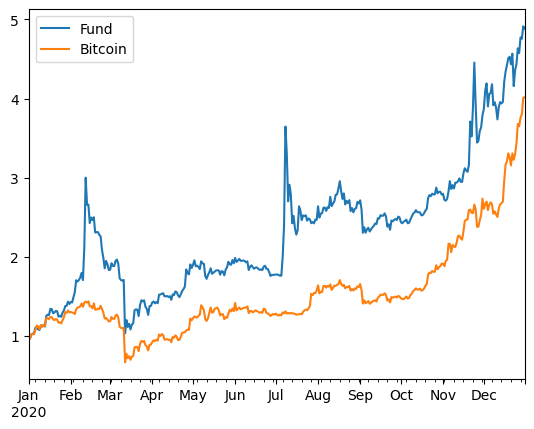

In [30]:
(1+performance_pct.loc['2020':'2020']).cumprod().plot()

In [31]:
years=sorted(list(set(performance.index.year)))

month_year=performance.index.strftime('%Y-%m')
month_year=sorted(list(set(month_year)))

<Axes: >

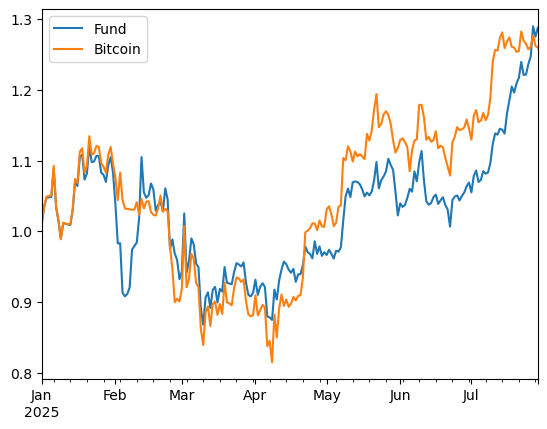

In [32]:
(1+performance_pct.loc['2025-01':]).cumprod().plot()

In [33]:
year_returns={}
year_vol={}
year_tracking_error={}
year_sharpe_ratio={}

for year in years:
    temp=performance.loc[str(year)].pct_change()
    year_vol[year]=temp.std()*np.sqrt(252)
    year_tracking_error[year]=(temp['Fund']-temp['Bitcoin']).std()*np.sqrt(252)
    perf_year=performance.loc[str(year)].iloc[-1]/performance.loc[str(year)].iloc[0]-1
    year_sharpe_ratio[year]=perf_year/(temp.std()*np.sqrt(252))
    year_returns[year]=perf_year


In [34]:
year_returns_dataframe=pd.DataFrame(year_returns)
year_returns_dataframe

,2020,2021,2022,2023,2024,2025
Fund,3.885358,17.669992,-0.562366,1.802844,3.089470,0.271239
Bitcoin,3.016697,0.575665,-0.653364,1.544636,1.118084,0.245548


In [35]:
year_vol_dataframe=pd.DataFrame(year_vol)
year_vol_dataframe

,2020,2021,2022,2023,2024,2025
Fund,0.945739,1.082422,0.523909,0.436180,0.570295,0.357420
Bitcoin,0.628005,0.674692,0.529548,0.366637,0.440220,0.370565


In [36]:
year_tracking_error_dataframe=pd.DataFrame(year_tracking_error.items(),columns=['Date','Tracking Error']).set_index('Date').T.round(6)
year_tracking_error_dataframe

Date,2020,2021,2022,2023,2024,2025
Tracking Error,0.74991,0.778004,0.283655,0.349201,0.595977,0.24186


In [37]:
year_sharpe_ratio_dataframe=pd.DataFrame(year_sharpe_ratio)
year_sharpe_ratio_dataframe

,2020,2021,2022,2023,2024,2025
Fund,4.108275,16.324500,-1.073404,4.133261,5.417317,0.758882
Bitcoin,4.803620,0.853228,-1.233814,4.212980,2.539829,0.662631


In [38]:
month_returns={}
month_vol={}
month_tracking_error={}
monthly_sharpe_ratio={}

for month in month_year:
    temp=performance.loc[str(month)].pct_change()
    month_vol[month]=temp.std()*np.sqrt(252)
    month_tracking_error[month]=(temp['Fund']-temp['Bitcoin']).std()*np.sqrt(252)
    perf_year=performance.loc[str(month)].iloc[-1]/performance.loc[str(month)].iloc[0]-1
    month_returns[month]=perf_year
    monthly_sharpe_ratio[month]=perf_year/(temp.std()*np.sqrt(252))
    
#month_returns[month]=performance.loc[str(month_year[-1])].iloc[-2]/performance.loc[str(month_year[-1])].iloc[0]-1

In [39]:
month_returns_dataframe=pd.DataFrame(month_returns)
month_returns_dataframe

,2020-01,2020-02,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,...,2024-10,2024-11,2024-12,2025-01,2025-02,2025-03,2025-04,2025-05,2025-06,2025-07
Fund,0.403840,0.283628,-0.248649,0.305888,0.009843,-0.106820,0.389475,0.013863,-0.079801,0.143906,...,0.068067,1.111186,0.118492,0.069271,-0.101390,-0.031995,0.041606,0.057675,0.028134,0.220035
Bitcoin,0.298859,-0.091746,-0.248649,0.297622,0.070388,-0.104131,0.227844,-0.012851,-0.096073,0.298694,...,0.156009,0.387245,-0.037137,0.082859,-0.161828,-0.040836,0.105846,0.083967,0.014233,0.114850


In [40]:
month_vol_dataframe=pd.DataFrame(month_vol)
month_vol_dataframe

,2020-01,2020-02,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,...,2024-10,2024-11,2024-12,2025-01,2025-02,2025-03,2025-04,2025-05,2025-06,2025-07
Fund,0.564461,1.642768,1.510124,0.563207,0.449464,0.255791,1.898498,0.452253,0.481154,0.232996,...,0.164515,1.050989,1.374071,0.345561,0.538553,0.502249,0.293781,0.263117,0.246309,0.192666
Bitcoin,0.485429,0.432844,1.510124,0.618220,0.582460,0.347506,0.372178,0.362277,0.464560,0.295867,...,0.301765,0.514331,0.367845,0.360415,0.321861,0.561475,0.457074,0.299972,0.269304,0.217495


In [41]:
month_tracking_error_dataframe=pd.DataFrame(month_tracking_error.items(),columns=['Date','Tracking Error']).set_index('Date').T.round(6)
month_tracking_error_dataframe

Date,2020-01,2020-02,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,...,2024-10,2024-11,2024-12,2025-01,2025-02,2025-03,2025-04,2025-05,2025-06,2025-07
Tracking Error,0.268808,1.465748,0.0,0.457321,0.337406,0.178651,1.892523,0.219226,0.066212,0.118031,...,0.296482,1.120846,1.356644,0.02342,0.454943,0.087466,0.261995,0.253412,0.224796,0.167696


In [42]:
month_sharpe_ratio_dataframe=pd.DataFrame(monthly_sharpe_ratio)
month_sharpe_ratio_dataframe

,2020-01,2020-02,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,...,2024-10,2024-11,2024-12,2025-01,2025-02,2025-03,2025-04,2025-05,2025-06,2025-07
Fund,0.715443,0.172653,-0.164654,0.543118,0.021898,-0.417607,0.205149,0.030653,-0.165853,0.617630,...,0.413741,1.057276,0.086234,0.200461,-0.188264,-0.063704,0.141622,0.219199,0.114222,1.142057
Bitcoin,0.615660,-0.211961,-0.164654,0.481418,0.120846,-0.299654,0.612192,-0.035474,-0.206804,1.009555,...,0.516988,0.752909,-0.100959,0.229898,-0.502791,-0.072730,0.231573,0.279916,0.052849,0.528057


In [43]:
metrics={}
metrics['Tracking Error']=(performance_pct['Fund']-performance_pct['Bitcoin']).std()*np.sqrt(252)
metrics['Fund Vol']=performance_pct['Fund'].std()*np.sqrt(252)
metrics['Bench Vol']=performance_pct['Bitcoin'].std()*np.sqrt(252)
metrics['Fund Return']=performance['Fund'].iloc[-2]/performance['Fund'].iloc[0]
metrics['Bench Return']=performance['Bitcoin'].iloc[-2]/performance['Bitcoin'].iloc[0]
metrics['Sharpe Ratio']=(1+metrics['Fund Return'])**(1/len(set(returns_to_use.index.year)))/metrics['Fund Vol']

In [44]:
indicators=pd.DataFrame(metrics.values(),index=metrics.keys(),columns=['Indicators'])
indicators

,Indicators
Tracking Error,0.562583
Fund Vol,0.725764
Bench Vol,0.525394
Fund Return,596.212346
Bench Return,16.395609
Sharpe Ratio,3.433955


In [45]:
last_weights=tracking[dates_end[-3]][0]
weights=pd.DataFrame(last_weights.values(),index=last_weights.keys(),columns=['Weights Model'])

current_positions=Binance.get_inventory().round(4)
current_positions.columns=['Current Portfolio in USDT','Current Weights']
amount=current_positions.loc['Total']['Current Portfolio in USDT']

last_prices=Binance.get_price(list(last_weights.keys()))

quantities={}

for key in last_weights:
    quantities[key]=amount*last_weights[key]#/last_prices[key].values[0]

positions=pd.DataFrame(quantities.values(),index=quantities.keys(),columns=['Mark To Market Model'])
positions=pd.concat([positions,weights],axis=1)

condition=current_positions.index!='Total'
portfolio=pd.concat([positions,current_positions.loc[condition]],axis=1).fillna(0)
portfolio.loc['Total']=portfolio.sum(axis=0)
portfolio.sort_values(by='Weights Model',ascending=False).round(4)

,Mark To Market Model,Weights Model,Current Portfolio in USDT,Current Weights
Total,2132.0889,1.0000,2132.0867,1.0000
BNBUSDT,1045.1809,0.4902,1.3796,0.0006
TRXUSDT,745.5119,0.3497,163.5273,0.0767
BTCUSDT,341.3961,0.1601,1042.7867,0.4891
DOGEUSDT,0.0000,0.0000,0.0000,0.0000
XRPUSDT,0.0000,0.0000,0.0000,0.0000
ADAUSDT,0.0000,0.0000,0.0000,0.0000
XLMUSDT,0.0000,0.0000,0.0000,0.0000
ETHUSDT,0.0000,0.0000,260.7920,0.1223
BCHUSDT,0.0000,0.0000,0.0000,0.0000


In [46]:
git.create_or_replace_notebook("Active Crypto Strategy.ipynb")

File 'Active Crypto Strategy.ipynb' exists. Replacing the file...
✅ File 'Active Crypto Strategy.ipynb' successfully pushed/updated to GitHub!


In [47]:
dates_end2=dates_end.copy()
dates_end2=dates_end2[:-1]
date=dates_end2[-2]
last_weights=tracking[date][0]
weights=pd.DataFrame(last_weights.values(),index=last_weights.keys(),columns=[date])
weights

,2025-06-30
BTCUSDT,0.160123
ETHUSDT,0.000000
XRPUSDT,0.000000
BNBUSDT,0.490215
DOGEUSDT,0.000000
TRXUSDT,0.349663
ADAUSDT,0.000000
XLMUSDT,0.000000
LINKUSDT,0.000000
BCHUSDT,0.000000


In [48]:
history={}

for date in tracking:

    history[date]=tracking[date][0]

In [49]:
np.sum(pd.DataFrame(history).T>0,axis=0).sort_values()/len(tracking.keys())

LINKUSDT    0.072464
ADAUSDT     0.086957
ETHUSDT     0.101449
BCHUSDT     0.115942
XRPUSDT     0.231884
DOGEUSDT    0.231884
HBARUSDT    0.231884
XLMUSDT     0.246377
BNBUSDT     0.507246
BTCUSDT     0.623188
TRXUSDT     0.695652
dtype: float64